In [ ]:
# pip install -r requirements.txt

In [37]:
""" Importing libraries """

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
from tensorflow import data as tf_data


from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D , MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import glob
import xml.etree.cElementTree as et

In [38]:
""" Unzipping data set to a local directory  """

working_directory = "F:\\Coding\\cv_challenge\\archive.zip"             # Change working directory to directory contaioning archive.zip

from zipfile import ZipFile

with ZipFile(working_directory, 'r') as Dataset:              
    Dataset.extractall()

## Task 1 : Convert image data into TFRecordDataset format

In [39]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

#### Creating image list and paths

In [40]:
# Define paths for data folders   
data_folder = ('F:\\Coding\\cv_challenge\\NEU-DET')                                           
train_folder_path = os.path.join(data_folder, "train", )
valid_folder_path = os.path.join(data_folder, "validation",)

# Function to create a list of image paths from a given folder
def create_img_list(folder_path):
    image_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image_list.append(image_path)

    return image_list

# Obtain lists of image paths for training and validation sets
train_img_list = create_img_list(train_folder_path)
valid_img_list = create_img_list(valid_folder_path)

# Define paths for annotation folders
train_anno_path = os.path.join(data_folder,"train", "annotations")
valid_anno_path = os.path.join(data_folder,"validation", "annotations")

# Get lists of annotation files
train_anno_files_list = os.listdir(train_anno_path)
valid_anno_files_list = os.listdir(valid_anno_path)

#### Extracting Lables from XML files

In [41]:
""" 
Function to parse XML files and extract relevant information such as filename, source ID, image size, and object bounding boxes.

Args:
    xmlfile (str): Path to the XML file containing object annotations.

Returns:
    dict: A dictionary containing parsed information including filename, source ID, image size, and object details.

Sample usage:
    xml_file_path = 'F:\\Coding\\cv_challenge\\NEU-DET\\train\\annotations\\inclusion_45.xml'
    image_file_path = 'F:\\Coding\\cv_challenge\\NEU-DET\\train\\images\\inclusion\\inclusion_45.jpg'
    bounding_boxes_data = parseXML(xml_file_path)
"""

def parseXML(xmlfile):
    # create element tree object 
    tree = et.parse(xmlfile)  
    # get root element 
    root = tree.getroot()

    data = {}
    data['filename'] = root.find('filename').text
    
    source = root.find('source')
    if source is not None:
        data['source_id'] = source.find('database').text
    else:
        data['source_id'] = None

    size = root.find('size')
    data['size'] = {
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }
    
    objects = []
    for obj in root.findall('object'):
        obj_data = {
            'name': obj.find('name').text,
            'pose': obj.find('pose').text,
            'truncated': int(obj.find('truncated').text),
            'difficult': int(obj.find('difficult').text),
            'bndbox': {
                'xmin': int(obj.find('bndbox/xmin').text),
                'ymin': int(obj.find('bndbox/ymin').text),
                'xmax': int(obj.find('bndbox/xmax').text),
                'ymax': int(obj.find('bndbox/ymax').text)
            }
        }
        objects.append(obj_data)

    data['objects'] = objects

    return data



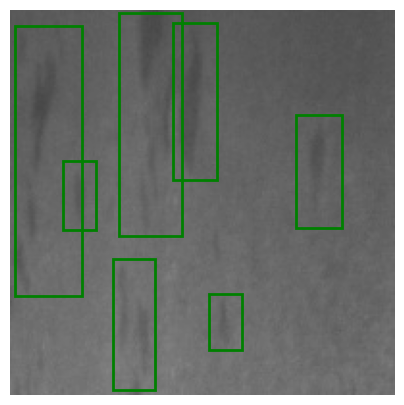

In [42]:
"""
Displaying a sample image with multiple bounding boxes
"""

# Sample data paths
xml_file_path = 'F:\\Coding\\cv_challenge\\NEU-DET\\train\\annotations\\inclusion_45.xml'
image_file_path = 'F:\\Coding\cv_challenge\\NEU-DET\\train\\images\\inclusion\\inclusion_45.jpg'

# Load XML file and parse it
bounding_boxes_data = parseXML(xml_file_path)

# Load image
image_raw = tf.io.read_file(image_file_path)
image = tf.image.decode_jpeg(image_raw)

# Draw bounding boxes on the image

plt.figure(figsize=(5,5))
plt.imshow(image)
ax = plt.gca()
for obj in bounding_boxes_data['objects']:
    xmin = obj['bndbox']['xmin']
    ymin = obj['bndbox']['ymin']
    xmax = obj['bndbox']['xmax']
    ymax = obj['bndbox']['ymax']
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    # ax.text(xmin, ymin - 8, label, fontsize=10, color='green', verticalalignment='top')
plt.axis('off')
plt.show()


#### Get distinct class labels

In [43]:
"""
Get distinct class labels from xml files
Returns a list of distinct labels
"""

labels = []
for anno in train_anno_files_list:
    attr = parseXML(train_anno_path +"\\"+anno)
    for obj in attr['objects']:
        label = obj["name"]
        if label not in labels:
            labels.append(label)

print(labels)

"""
Assigning distinct values to each distinct label
"""
image_labels = {name: index for index, name in enumerate(labels)}
n_class = len(image_labels)
print(image_labels)


['crazing', 'patches', 'inclusion', 'pitted_surface', 'rolled-in_scale', 'scratches']
{'crazing': 0, 'patches': 1, 'inclusion': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


#### Define get_image_example method to create a TF Example

In [44]:
""" Creates a TF Example containing image features and object annotations. 

    Args: A dictonary of features

    Returns:
        tf.train.Example: TF Example containing image features and object annotations.
"""

def get_image_example(image_string, source_id, width, height, filename, xmin, xmax, ymin, ymax, label, label_text, truncated, difficult):

  # Create a dictionary of features
  feature = {
        "image/width": _int64_feature(width),
        "image/height": _int64_feature(height),
        "image/filename":_bytes_feature(bytes(filename, 'utf-8')),
        'image/source_id': _bytes_feature(bytes(source_id, 'utf-8')),
        "image/encodedrawdata": _bytes_feature(image_string),
        "image/format": _bytes_feature(bytes(filename.split(".")[-1], 'utf-8')),  # Assuming filename contains format
        "image/object/bbox/xmin": _float_feature(xmin),
        "image/object/bbox/xmax": _float_feature(xmax),
        "image/object/bbox/ymin": _float_feature(ymin),
        "image/object/bbox/ymax": _float_feature(ymax),
        "image/object/class/text": _bytes_feature(bytes(label_text, 'utf-8')),
        "image/object/class/label": _int64_feature(label),
        "image/object/class/single": _int64_feature(label),  # Assuming single class per object
        "image/object/difficult": _int64_feature(truncated),
        "image/object/truncated": _int64_feature(difficult),
        "image/object/view": _bytes_feature(bytes("Unspecified", 'utf-8'))  # Assuming view is Unspecified for simplicity
        
    }
  # Create a TF Example with the features
  return tf.train.Example(features=tf.train.Features(feature=feature))

  """
  Followed the article of Reading-Writing TFRecord for Images
  https://www.tensorflow.org/tutorials/load_data/tfrecord
  """

#### Define convert method to convert image data and annotation information into TFRecord format

In [45]:
"""
    Converts image data and annotation information into TFRecord format.

    Args:
        image_paths (list): List of file paths to images.
        anno_list (list): List of annotation file names.
        anno_path (str): Path to the directory containing annotation files.
        out_path (str): Path to the directory where TFRecord files will be saved.

"""

def convert(image_paths,anno_list,anno_path, out_path):

    for img in image_paths:

        img_name_ext = img.split("\\")[-1]
        img_name = img_name_ext.split('.')[0]

        for anno in anno_list:
            anno_name = anno.split(".")[0]
    

            if img_name == anno_name:
                attr = parseXML(anno_path +"\\"+anno)

                image_string = open(img, 'rb').read()

                filename = attr["filename"]
                source_id = attr["source"]["database"] if "source" in attr and "database" in attr["source"] else "Unknown"
                width = attr["size"]["width"]
                height = attr["size"]["height"]

                for obj in attr['objects']:
                    xmin = obj['bndbox']['xmin']
                    ymin = obj['bndbox']['ymin']
                    xmax = obj['bndbox']['xmax']
                    ymax = obj['bndbox']['ymax']
                    label_text = obj["name"]
                    label = image_labels.get(label_text, -1)  # Get label index or -1 if not found
                    truncated = obj["truncated"]
                    difficult = obj["difficult"]


                image_string  = open((img), 'rb').read()
                tf_example = get_image_example(image_string, source_id, width, height, filename, xmin, xmax, ymin, ymax, label, label_text, truncated, difficult)

                file_name_ext = os.path.basename(img)
                file_name = os.path.splitext(file_name_ext)[0]
                output_filename = os.path.join(out_path, f'{file_name}.tfrecord')
                with tf.io.TFRecordWriter(output_filename) as writer:
                    writer.write(tf_example.SerializeToString())

#### Create .tfrecord files

In [46]:
out_path_training = 'F:\\Coding\\cv_challenge\\TF_Records\\Train'
out_path_validation = 'F:\\Coding\\cv_challenge\\TF_Records\\Test'

# Convert training images and annotations to TFRecord format
convert(train_img_list,train_anno_files_list ,train_anno_path , out_path_training)

# Convert validation images and annotations to TFRecord format
convert(valid_img_list,valid_anno_files_list, valid_anno_path ,out_path_validation)

#### Checking the Contents of a TFRecord File

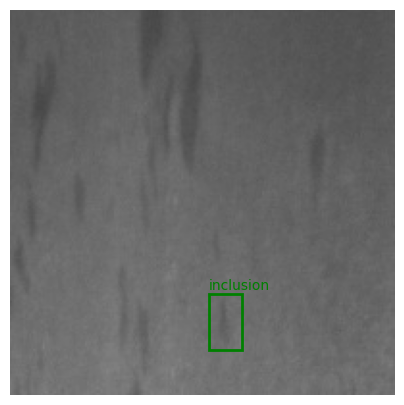

In [47]:
"""
Trying to run on one example to check if the .tfrecord files are correct

"""

tfr_train = "F:\Coding\cv_challenge\TF_Records\\train\inclusion_45.tfrecord"
raw_image_dataset = tf.data.TFRecordDataset(filenames = [tfr_train])


image_feature_description  = {
      "image/width": tf.io.FixedLenFeature([], tf.int64),
      "image/height": tf.io.FixedLenFeature([], tf.int64),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/source_id': tf.io.FixedLenFeature([], tf.string),
      'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
      'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
      'image/object/difficult': tf.io.VarLenFeature(tf.int64),
      'image/object/truncated': tf.io.VarLenFeature(tf.int64),
      'image/object/view': tf.io.VarLenFeature(tf.string)
  }

def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, image_feature_description )

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)


def draw_bounding_boxes(image, bboxes, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    ax = plt.gca()
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 8, label, fontsize=10, color='green', verticalalignment='top')
    plt.axis('off')
    plt.show()

for image_features in parsed_image_dataset:
    image_raw = image_features['image/encodedrawdata'].numpy()
    image = tf.image.decode_jpeg(image_raw)
    filename = image_features['image/filename'].numpy().decode("utf-8")
    bboxes = np.stack([
        image_features["image/object/bbox/xmin"].values.numpy(),
        image_features["image/object/bbox/ymin"].values.numpy(),
        image_features["image/object/bbox/xmax"].values.numpy(),
        image_features["image/object/bbox/ymax"].values.numpy()
    ], axis=-1)
    box_labels = image_features["image/object/class/text"].values.numpy().astype(str)
    draw_bounding_boxes(image, bboxes, box_labels)

## Task 2 - Classification

### Building the model

In [48]:
# Define the dimensions of the input images from xml files
image_height = 200
image_width = 200
n_color_channels = 3                                        # rgb image
image_size = [image_height,image_width]

# Load the pre-trained Xception model with weights trained on ImageNet
base_model = tf.keras.applications.Xception(input_shape=(*[image_height,image_width ],
                                                         n_color_channels),
                                                         include_top=False,
                                                         weights="imagenet")

# Freeze the weights of the base model (prevent them from being updated during training)
base_model.trainable = False

# Define input layer for the model
inputs = keras.Input(shape=(image_height, image_width, n_color_channels))

x = base_model(inputs, training=False)                      # Pass input through the base model (Xception)
x = keras.layers.BatchNormalization()(x)                    # Apply Batch Normalization layer to the output of base model
x = keras.layers.GlobalAveragePooling2D()(x)                # Apply Global Average Pooling 2D to reduce spatial dimensions
x = keras.layers.Dense(8)(x)                                # Add a Dense layer with 8 units (neurons)
x = keras.layers.Dropout(0.4)(x)                            # Regularize with dropout to prevent overfitting
outputs = keras.layers.Dense(6, activation='relu')(x)       # Add output layer with 6 units (for 6 classes) and ReLU activation function

# Define the model with input and output layers
model = keras.Model(inputs, outputs)


# Display the summary of the model architecture, showing trainable parameters
model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        2086148   N          
                                                       0                    
                                                                            
 batch_normalization_9 (Bat  (None, 7, 7, 2048)        8192      Y          
 chNormalization)                                                           
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                           

### Compiling the Model

#### Converting TFRecords to TFRecordDataset

In [49]:
"""Converting tfrecords into dataset"""

tfr_train_path = glob.glob("F:\Coding\cv_challenge\TF_Records\Train\*.tfrecord")
tfr_validation_path = glob.glob("F:\Coding\cv_challenge\TF_Records\Test\*.tfrecord")

train_dataset = tf.data.TFRecordDataset(tfr_train_path)
validation_dataset = tf.data.TFRecordDataset(tfr_train_path)

In [50]:
"""Decoding the image"""

def decode_image(image, color_channels):
    image = tf.image.decode_jpeg(image, channels = color_channels)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*image_size, 3])
    return image

In [51]:
"""Funtion to read tfrecord files"""

def read_tfrecord(example_proto):

    image_feature_description  = {
      "image/width": tf.io.FixedLenFeature([], tf.int64),
      "image/height": tf.io.FixedLenFeature([], tf.int64),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/source_id': tf.io.FixedLenFeature([], tf.string),
      'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
      'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
      'image/object/difficult': tf.io.VarLenFeature(tf.int64),
      'image/object/truncated': tf.io.VarLenFeature(tf.int64),
      'image/object/view': tf.io.VarLenFeature(tf.string)
    }
    
    example = tf.io.parse_single_example(example_proto, image_feature_description)

    decoded_image = decode_image(example["image/encodedrawdata"], n_color_channels)
    label = tf.cast(tf.sparse.to_dense(example["image/object/class/label"]), tf.int32)  

    return decoded_image, label

In [52]:
""" 
Map the read_tfrecord function to each example in the training and validation dataset to decode the TFRecord files
"""

mapped_train_dataset = train_dataset.map(read_tfrecord)
mapped_validation_dataset = validation_dataset.map(read_tfrecord)

In [53]:
BATCH_SIZE = 64                                 # Define the batch size for training and validation datasets
BUFFER_SIZE = 1000                              # Define the buffer size for shuffling the training dataset

# Batch and prefetch the mapped training and validation dataset, cache it in memory for faster access,
# shuffle the dataset with the specified buffer size

train_ds = mapped_train_dataset.batch(BATCH_SIZE).prefetch(tf_data.AUTOTUNE).cache().shuffle(BUFFER_SIZE)
validation_ds = mapped_validation_dataset.batch(BATCH_SIZE).prefetch(tf_data.AUTOTUNE).cache().shuffle(BUFFER_SIZE)

In [54]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # metrics=[keras.metrics.Accuracy()],
)

### Training the Model

In [55]:
# Total number of epochs for training
epochs = 3                                                                   

# Learning rate scheduler function based on epoch number
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 15:
        return 0.001
    elif epoch < 22:
        return 0.0005
    else:
        return 0.0001

# Reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=1e-6)

# Stop training when a monitored metric has stopped improvin
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)


# Schedule learning rate after a certain number of epochs
shift_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Train the model on the training dataset

model_history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[reduce_lr,early_stop, shift_lr])

"""
model.fit: Trains the model using the provided training dataset (train_ds) for a specified number of epochs (epochs).

validation_data: Specifies the validation dataset (validation_ds) to evaluate the model's performance after each epoch.

callbacks: A list of callbacks to apply during training, including reducing learning rate on plateau (reduce_lr),
            early stopping (early_stop), and scheduling learning rate (shift_lr).
            
"""

### Model Performance

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_ds)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

# final_val_accuracy = model_history.history['val_sparse_categorical_accuracy'][-1]
# print("Final Validation Accuracy:", final_val_accuracy)


def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['sparse_categorical_accuracy']
    val_accuracy = model_history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(model_history)

## Task 3: Object Detection

In [ ]:
pip install tensorflow keras_cv matplotlib

In [58]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as et

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [59]:
print(image_labels)

{'crazing': 0, 'patches': 1, 'inclusion': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


In [60]:
# Obtain lists of image paths for training and validation sets
train_img_list = create_img_list(train_folder_path)
valid_img_list = create_img_list(valid_folder_path)

# Define paths for annotation folders
train_anno_path = os.path.join(data_folder,"train", "annotations")
valid_anno_path = os.path.join(data_folder,"validation", "annotations")

# Get lists of annotation files
train_anno_files_list = os.listdir(train_anno_path)
valid_anno_files_list = os.listdir(valid_anno_path)

In [61]:
# Get all XML file paths in path_annot and sort them
train_xml_files = sorted([os.path.join(train_anno_path, anno) for anno in train_anno_files_list])
valid_xml_files = sorted([os.path.join(valid_anno_path, anno) for anno in valid_anno_files_list])

# Get all JPEG image file paths in path_images and sort them
train_jpg_files = sorted(train_img_list)
valid_jpg_files = sorted(valid_img_list)

In [62]:
# image_path, boxes, class_ids = parseXML()

def create_dataset(xml_files, jpg_files):
    image_paths = []
    bbox = []
    classes = []
    for xml_file in tqdm(xml_files):
        try:
            xml_data = parseXML(xml_file)
            image_filename = xml_data['filename']
            
            # Find the corresponding image path from jpg_files
            image_path = [jpg_file for jpg_file in jpg_files if image_filename in jpg_file]
            if not image_path:
                # Skip this iteration if image path is not found
                continue
            
            image_path = image_path[0]  # Get the first found image path
            boxes = [[obj['bndbox']['xmin'], obj['bndbox']['ymin'], obj['bndbox']['xmax'], obj['bndbox']['ymax']] for obj in xml_data['objects']]
            class_names = [obj['name'] for obj in xml_data['objects']]
            class_ids = [image_labels[class_name] for class_name in class_names]  # Map class names to class labels

            image_paths.append(image_path)
            bbox.append(boxes)
            classes.append(class_ids)
        except Exception as e:
            # Skip this iteration if any exception occurs
            pass

    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    # print(image_paths[236:244])

    return tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))



In this case, the bbox and classes lists have different lengths for each image, depending on the number of objects in the image and the corresponding bounding boxes and classes. To handle this variability, ragged tensors are used instead of regular tensors.

Later, these ragged tensors are used to create a tf.data.Dataset using the from_tensor_slices method. This method creates a dataset from the input tensors by slicing them along the first dimension. By using ragged tensors, the dataset can handle varying lengths of data for each image and provide a flexible input pipeline for further processing.

In [63]:
# Create datasets for train and validation
train_data = create_dataset(train_xml_files, train_jpg_files)
val_data = create_dataset(valid_xml_files, valid_jpg_files)
 
# print(train_data)
# print(val_data)

100%|██████████| 361/361 [00:00<00:00, 1856.19it/s]


In [64]:
BATCH_SIZE_1 = 16

In [65]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [66]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(3.2, 3.2),
    bounding_box_format="xyxy",
)

In [67]:
train_ds_od = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_od = train_ds_od.shuffle(BATCH_SIZE_1*4)
train_ds_od = train_ds_od.ragged_batch(BATCH_SIZE_1, drop_remainder=True)
train_ds_od = train_ds_od.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_od

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(16, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([16, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([16, None, None]), tf.float32, 1, tf.int64)}}>

In [68]:
val_ds_od = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_od = val_ds_od.shuffle(BATCH_SIZE_1 * 4)
val_ds_od = val_ds_od.ragged_batch(BATCH_SIZE_1, drop_remainder=True)
val_ds_od = val_ds_od.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

val_ds_od

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(16, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([16, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([16, None, None]), tf.float32, 1, tf.int64)}}>

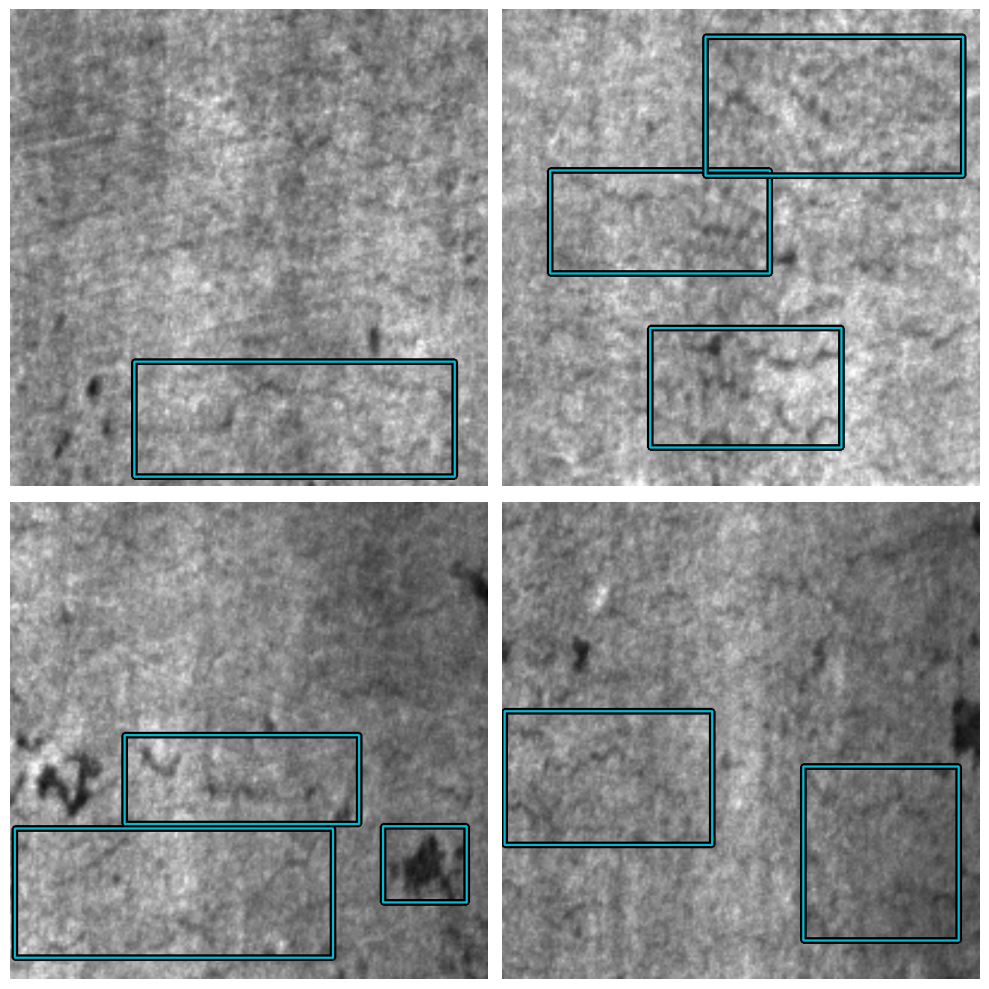

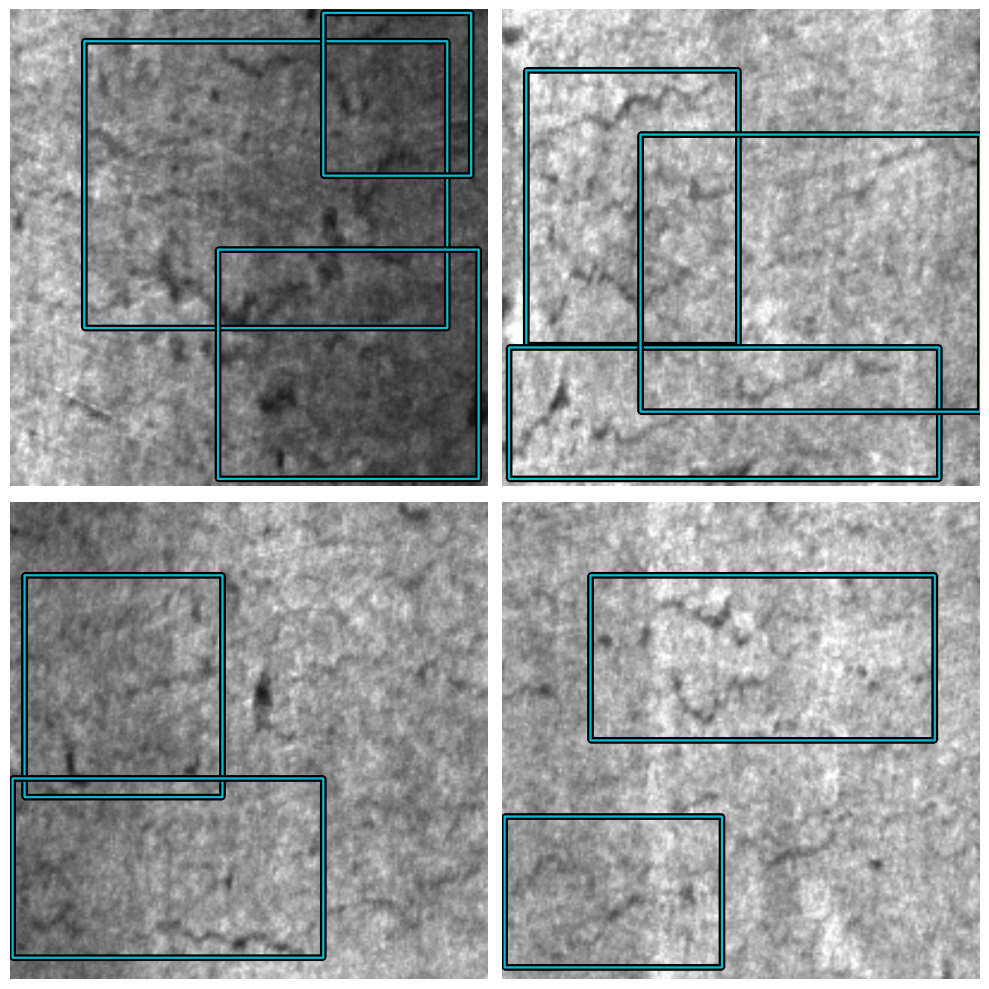

In [70]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    # print(images,bounding_boxes)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.5,
        bounding_box_format=bounding_box_format,
        class_mapping=image_labels,
    )


visualize_dataset(
    train_ds_od, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds_od, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [71]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds_od = train_ds_od.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_od = train_ds_od.prefetch(tf.data.AUTOTUNE)

val_ds_od = val_ds_od.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_od = val_ds_od.prefetch(tf.data.AUTOTUNE)

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(image_labels),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
LEARNING_RATE = 0.001
GLOBAL_CLIPNORM = 10.0

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [ ]:
yolo.fit(
    train_ds_od,
    validation_data=val_ds_od,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds_od, "model.h5")],
)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=image_labels,
    )


visualize_detections(yolo, dataset=val_ds_od, bounding_box_format="xyxy")